# Detecting Topic Shifts in Conversations with Semantic Analysis

This notebook aims to detect topic shifts in conversations through semantic analysis. By utilizing vector embeddings, we can perceive subtle changes in semantic similarity, which helps identify potential shifts in conversation topics.

In [1]:
%pip install cohere scikit-learn matplotlib seaborn 


Note: you may need to restart the kernel to use updated packages.


In [3]:
%pip install semantic-router==0.0.15 


  Attempting uninstall: semantic-router
    Found existing installation: semantic-router 0.0.16
    Uninstalling semantic-router-0.0.16:
      Successfully uninstalled semantic-router-0.0.16


In [ ]:
# # %pip install cmake
# %pip install --upgrade setuptools wheel
# %pip install llama-cpp-python

### Embedding Model

We will use cohere's recent `embed-english-v3.0` model for generating the embeddings

In [5]:
import os
import cohere
from semantic_router.utils.splitters import semantic_splitter
from semantic_router.encoders import CohereEncoder
encoder = CohereEncoder(cohere_api_key="L3SLQxnOJHhLeAEPx9UrO0YVZpGEsNlDb7ITufYR")

co = cohere.Client("L3SLQxnOJHhLeAEPx9UrO0YVZpGEsNlDb7ITufYR")


def embed_documents(documents: list[str]) -> list[list[float]]:
    emb = co.embed(
        documents,
        input_type="search_document",
        model="embed-english-v3.0",
    ).embeddings
    return emb

### Confusion Matrix

In [6]:
convo = [
    "User: Hi there! Can you tell me the current temperature?",
    "Bot: Hello! It's currently 68°F.",
    "User: That's quite pleasant. I'm thinking of going for a run.",
    "Bot: That sounds like a great idea. Do you need any running tips?",
    "User: Yes, how can I improve my stamina?",
    "Bot: There are several ways to improve stamina, including interval training and cross-training.",
    "User: Thanks for the advice! By the way, do you have any book recommendations?",
    "Bot: Sure, what genre are you interested in?",
    "User: I enjoy mystery novels.",
    "Bot: I would recommend 'The Girl with the Dragon Tattoo' by Stieg Larsson.",
    "User: Sounds interesting, I'll check it out. I also need some advice on home gardening.",
    "Bot: Of course, what do you need help with?",
    "User: I'm having trouble growing tomatoes.",
    "Bot: Tomato plants need plenty of sunlight and well-drained soil. Also, make sure you're watering them correctly.",
    "User: I'll keep that in mind. Thanks for your help!",
    "Bot: You're welcome! If you have any other questions, feel free to ask.",
    "User: Will do. Goodbye for now!",
    "Bot: Goodbye! Have a great day!"
]

Looking at the conversation above, we can observe several topic changes. The discussion transitions from asking about the current temperature in the first two messages and then to running tips between the third and sixth messages. From the seventh message, the topic then shifts to book recommendations, and continues to evolve, covering topics like home gardening.

Let's construct a confusion matrix to see if we notice any drops in similarity when there is a topic 
change


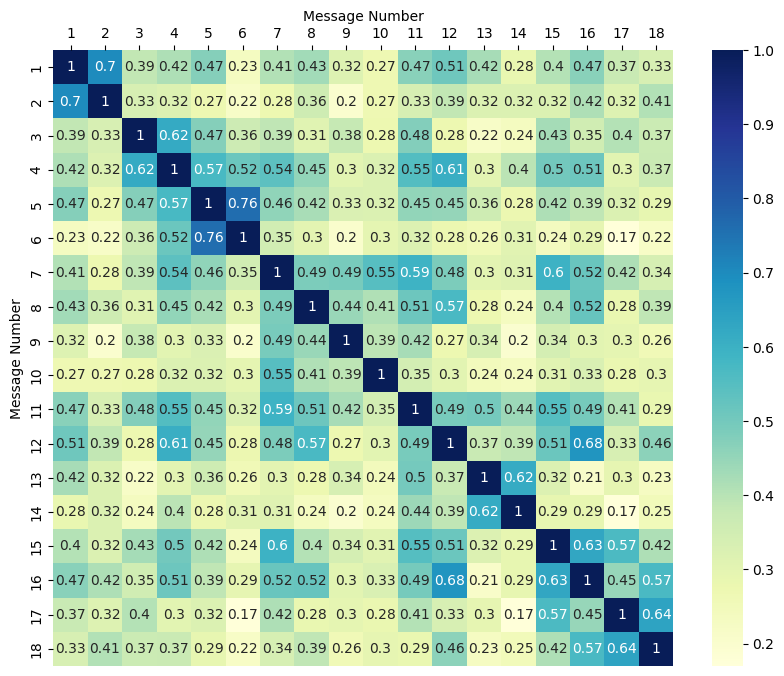

In [7]:
from sklearn.metrics.pairwise import cosine_similarity
import seaborn as sns
import matplotlib.pyplot as plt


embeddings = embed_documents(convo)
similarity_matrix = cosine_similarity(embeddings)

plt.figure(figsize=(10, 8))
ax = sns.heatmap(
    similarity_matrix,
    annot=True,
    cmap="YlGnBu",
    xticklabels=range(1, len(convo) + 1),
    yticklabels=range(1, len(convo) + 1),
)
ax.xaxis.tick_top()  # x axis on top
ax.xaxis.set_label_position("top")
# plt.title('Confusion Matrix between Messages')
plt.xlabel('Message Number')
plt.ylabel('Message Number')
plt.show()

We observe that messages 1 and 2 have a high similarity score of 0.73. However, when the topic changes to running tips between messages 2 and 3, the score drops to 0.43. Similarly, messages 3 and 4, 4 and 5, and 5 and 6 have high similarity scores. When the topic shifts to book recommendations at message 7, the similarity score between messages 6 and 7 droped to 0.5. We can leverage these changes to segment the conversation into different topics.


### Segment Conversation Based on Topic Shifts


#### Approach 1:

In this approach, we segment the conversation based on the similarity scores between consecutive messages. We assume that a significant decrease in similarity score beyond a set threshold between consecutive messages indicates a potential topic change.

In [8]:
embeddings = embed_documents(convo)
similarity_matrix = cosine_similarity(embeddings)


threshold = 0.48

for i, sentence in enumerate(convo, start=1):
    print(sentence)
    # check whether similarity between two consecutive messeges are below the threshold
    if i < len(similarity_matrix) and similarity_matrix[i - 1][i] < threshold:
        print("-" * 100)

User: Hi there! Can you tell me the current temperature?
Bot: Hello! It's currently 68°F.
----------------------------------------------------------------------------------------------------
User: That's quite pleasant. I'm thinking of going for a run.
Bot: That sounds like a great idea. Do you need any running tips?
User: Yes, how can I improve my stamina?
Bot: There are several ways to improve stamina, including interval training and cross-training.
----------------------------------------------------------------------------------------------------
User: Thanks for the advice! By the way, do you have any book recommendations?
Bot: Sure, what genre are you interested in?
----------------------------------------------------------------------------------------------------
User: I enjoy mystery novels.
----------------------------------------------------------------------------------------------------
Bot: I would recommend 'The Girl with the Dragon Tattoo' by Stieg Larsson.
------------

It's not perfect, but we're getting there at spotting topic changes. Let's write a function to handle this, visualize the results, and run more tests.

In [9]:
def segment_by_similarity_drop(messages: list[str], threshold=0.55):
    num_sentences = len(messages)
    segments = {}
    start_index = 0
    topic_number = 1

    convo_emb = embed_documents(documents=messages)
    similarity_matrix = cosine_similarity(convo_emb)

    for i in range(1, num_sentences):
        if (
            i < len(similarity_matrix) and similarity_matrix[i - 1][i] < threshold
        ):  # Detect topic change
            segments[f"topic {topic_number}"] = messages[start_index:i]
            start_index = i
            topic_number += 1

    segments[f"topic {topic_number}"] = messages[start_index:]  # Add the last chunk
    return segments

In [10]:
segments = segment_by_similarity_drop(messages=convo)
segments

{'topic 1': ['User: Hi there! Can you tell me the current temperature?',
  "Bot: Hello! It's currently 68°F."],
 'topic 2': ["User: That's quite pleasant. I'm thinking of going for a run.",
  'Bot: That sounds like a great idea. Do you need any running tips?',
  'User: Yes, how can I improve my stamina?',
  'Bot: There are several ways to improve stamina, including interval training and cross-training.'],
 'topic 3': ['User: Thanks for the advice! By the way, do you have any book recommendations?'],
 'topic 4': ['Bot: Sure, what genre are you interested in?'],
 'topic 5': ['User: I enjoy mystery novels.'],
 'topic 6': ["Bot: I would recommend 'The Girl with the Dragon Tattoo' by Stieg Larsson."],
 'topic 7': ["User: Sounds interesting, I'll check it out. I also need some advice on home gardening."],
 'topic 8': ['Bot: Of course, what do you need help with?'],
 'topic 9': ["User: I'm having trouble growing tomatoes.",
  "Bot: Tomato plants need plenty of sunlight and well-drained soil. 

Let's print this as a nice table

In [11]:
%pip install tabulate colorama pandas 

In [12]:
from sklearn.metrics.pairwise import cosine_similarity
from colorama import Fore, Style
from tabulate import tabulate
import pandas as pd


def visualize_topic_segments(segments: dict[str, list]):
    colors = [
        Fore.BLUE,
        Fore.GREEN,
        Fore.RED,
        Fore.YELLOW,
        Fore.MAGENTA,
        Fore.CYAN,
        Fore.WHITE,
    ]
    rows = [
        {
            "Topic": colors[i % 7] + segment + Style.RESET_ALL,
            "Message": colors[i % 7] + message + Style.RESET_ALL,
        }
        for i, (segment, messages) in enumerate(segments.items())
        for message in messages
    ]

    df = pd.DataFrame(rows)
    print(tabulate(df, headers="keys", tablefmt="psql"))

Now let's try different threshold levels

In [15]:
segments = semantic_splitter(encoder=encoder,docs=convo,threshold=0.7,split_method='consecutive_similarity_drop')
visualize_topic_segments(segments)

+----+----------+-------------------------------------------------------------------------------------------------------------------+
|    | Topic    | Message                                                                                                           |
|----+----------+-------------------------------------------------------------------------------------------------------------------|
|  0 | split 1  | User: Hi there! Can you tell me the current temperature?                                                          |
|  1 | split 2  | Bot: Hello! It's currently 68°F.                                                                                  |
|  2 | split 3  | User: That's quite pleasant. I'm thinking of going for a run.                                                     |
|  3 | split 4  | Bot: That sounds like a great idea. Do you need any running tips?                                                 |
|  4 | split 5  | User: Yes, how can I improve my stamina?    

Let's try few more conversations

In [37]:
convo1 = [
    "User: Hi there! Can you tell me the current temperature?",
    "Bot: Hello! It's currently 68°F.",
    "User: That's quite pleasant. I'm thinking of going for a run.",
    "Bot: That sounds like a great idea. Do you need any running tips?",
    "User: Yes, how can I improve my stamina?",
    "Bot: There are several ways to improve stamina, including interval training and cross-training.",
    "User: Thanks for the advice! By the way, do you have any book recommendations?",
    "Bot: Sure, what genre are you interested in?",
    "User: I enjoy mystery novels.",
    "Bot: I would recommend 'The Girl with the Dragon Tattoo' by Stieg Larsson.",
    "User: Sounds interesting, I'll check it out. I also need some advice on home gardening.",
    "Bot: Of course, what do you need help with?",
    "User: I'm having trouble growing tomatoes.",
    "Bot: Tomato plants need plenty of sunlight and well-drained soil. Also, make sure you're watering them correctly.",
    "User: I'll keep that in mind. Thanks for your help!",
    "Bot: You're welcome! If you have any other questions, feel free to ask.",
    "User: Will do. Goodbye for now!",
    "Bot: Goodbye! Have a great day!"
]

convo2 = [
    "User: Hello! Can you tell me the latest news headlines?",
    "Bot: Hi! Sure, here are the top news headlines for today...",
    "User: That's quite interesting. I'm also looking for some new music to listen to.",
    "Bot: What genre do you prefer?",
    "User: I like pop music.",
    "Bot: You might enjoy the latest album by Dua Lipa.",
    "User: I'll give it a listen. Also, I'm planning a trip and need some travel tips.",
    "Bot: Sure, where are you planning to go?",
    "User: I'm thinking of visiting Italy.",
    "Bot: Italy is a beautiful country. Make sure to visit the Colosseum in Rome and the canals in Venice.",
    "User: Those sound like great suggestions. I also need some help with my diet.",
    "Bot: What kind of diet are you following?",
    "User: I'm trying to eat more protein.",
    "Bot: Include lean meats, eggs, and legumes in your diet for a protein boost.",
    "User: Thanks for the tips! I'll talk to you later.",
    "Bot: You're welcome! Don't hesitate to reach out if you need more help.",
    "User: I appreciate it. Goodbye!",
    "Bot: Goodbye! Take care!"
]

Function to get all conversations by conversation id ordered by timestamp from dataframe

In [16]:
df = pd.read_csv("output_file.csv")
def get_messages_by_conversation_id(df, conversation_id):
    # Filter the DataFrame based on the given conversation_id
    conversation_df = df[df['conversation_id'] == conversation_id]
    
    # Sort the filtered DataFrame by timestamp if applicable
    if 'timestamp' in conversation_df.columns:
        conversation_df = conversation_df.sort_values(by='timestamp')

    # Extract the 'message' column entries
    messages = conversation_df['message'].tolist()

    return messages

convo3 = get_messages_by_conversation_id(df, "0144ca44-bd66-4f56-9749-94d6ecff7cf8")
convo3

["Hello carlos2! I hope you're doing well today. How can I assist you? Is there anything specific you'd like to chat about or any questions you have in mind?",
 'Hey, how are you?',
 "I'm an AI, so I don't have feelings, but I'm here to assist you. How can I help you today?",
 'Hey, have you ever questioned the nature of your reality?',
 "As an AI, I don't have the capability to question the nature of reality. My purpose is to assist users with their inquiries and provide helpful information. Is there anything specific you would like to know or discuss?",
 'Ok thanks',
 "You're welcome! If you have any more questions or need further assistance, feel free to ask.",
 'Hey, please tell me a random story',
 'Sure! Once upon a time, in a faraway land, there was a brave knight named Sir Aurelio. He embarked on a quest to rescue a captured princess from an evil dragon. Along his journey, he encountered many challenges and faced dangerous creatures. With his courage and determination, Sir Aure